In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline



from sklearn.ensemble import RandomForestRegressor

# EconML
from econml.dml import LinearDMLCateEstimator, ForestDMLCateEstimator
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter

In [2]:
file_path = "https://msalicedatapublic.blob.core.windows.net/datasets/Pricing/pricing_sample.csv"
df = pd.read_csv(file_path)
df.head()

,account_age,age,avg_hours,days_visited,friends_count,has_membership,is_US,songs_purchased,income,price,demand
0,3,53,1.834234,2,8,1,1,4.903237,0.960863,1.0,3.917117
1,5,54,7.171411,7,9,0,1,3.330161,0.732487,1.0,11.585706
2,3,33,5.351920,6,9,0,1,3.036203,1.130937,1.0,24.675960
3,2,34,6.723551,0,8,0,1,7.911926,0.929197,1.0,6.361776
4,4,30,2.448247,5,8,1,0,7.148967,0.533527,0.8,12.624123


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
account_age        10000 non-null int64
age                10000 non-null int64
avg_hours          10000 non-null float64
days_visited       10000 non-null int64
friends_count      10000 non-null int64
has_membership     10000 non-null int64
is_US              10000 non-null int64
songs_purchased    10000 non-null float64
income             10000 non-null float64
price              10000 non-null float64
demand             10000 non-null float64
dtypes: float64(5), int64(6)
memory usage: 859.5 KB


## Thống kê mô tả
Trước hết, ta sẽ thăm dò trực quan dữ liệu, bằng 1 loạt regression plot, nhằm khảo sát liên hệ giữa các confounders W, hiệp biến X (Income) và Outcome Y (demand)

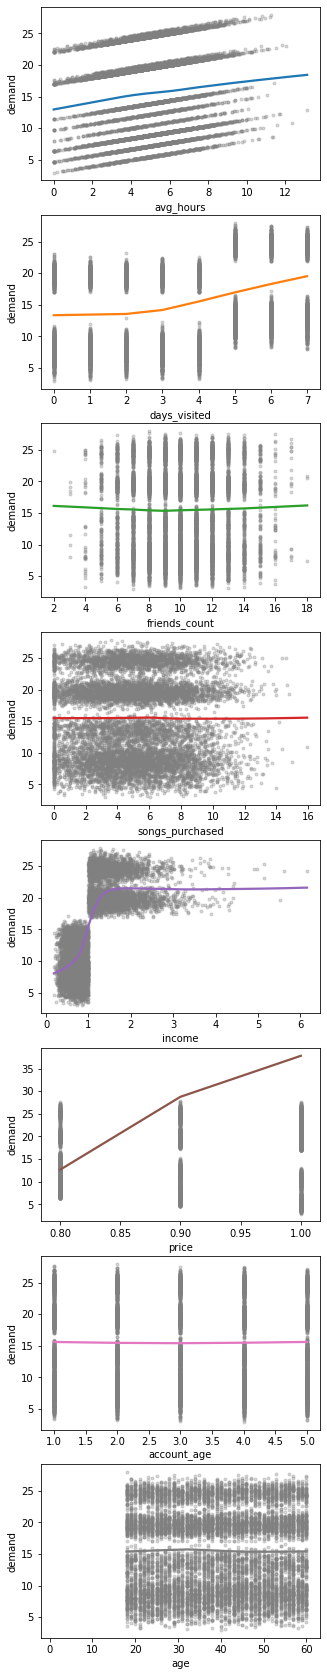

In [4]:
target = 'demand'
x_vars = ['avg_hours', 'days_visited', 
          'friends_count','songs_purchased', 
          'income','price','account_age', 'age',]

fig, axs = plt.subplots(nrows=len(x_vars), figsize=(5,30))

for i,v in enumerate(x_vars):
    g = sns.regplot(x=df[v].values, 
                y=df[target].values,
                lowess = True, 
                    marker = ".",
                scatter_kws={'alpha':0.3, 'color':'grey'},
                ax = axs[i])
    g.set(xlabel=v, ylabel=target)

[Text(0, 0.5, 'Doanh số'), Text(0.5, 0, 'Logarit Thu nhập')]

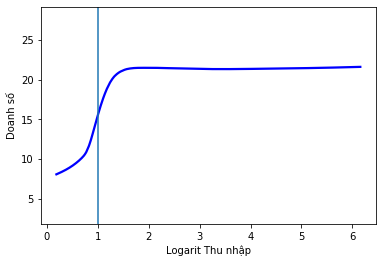

In [7]:
g = sns.regplot(x=df['income'].values, 
            y=df['demand'].values,
                lowess = True, 
                marker = ".",
                color = 'blue',
                scatter_kws={'alpha':0, 'color':None})

g.axvline(1)
g.set(xlabel='Logarit Thu nhập', ylabel='Doanh số')


Biểu đồ tương quan mức giá giảm và logarit thu nhập có hình dạng như sau:

Mức giảm giá trung bình cho nhóm khách hàng thu nhập thấp có thể dao động từ cao nhất là 15% đến thấp nhất là 10%. Ở nhóm khách hàng thu nhập cao, mức giảm giá trung bình từ 5% đến khoảng 2%

[Text(0, 0.5, 'Mức giảm giá'), Text(0.5, 0, 'Logarit thu nhập')]

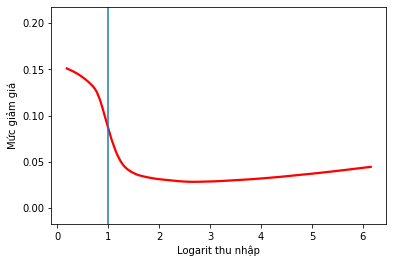

In [8]:
g = sns.regplot(x= df['income'].values, 
            y= np.round(1 - df['price'].values, 3),
            lowess = True, 
            marker = ".",
            color = 'red',
            scatter_kws={'alpha':0, 'color':None})

g.axvline(1)
g.set(xlabel='Logarit thu nhập', ylabel='Mức giảm giá')


Do chính sách giảm giá chịu chi phối đồng thời bởi quy luật cứng (thu nhập < 1) và mềm (phân bố ngẫu nhiên), sự tương phản về thu nhập ở 3 mức giảm giá 0, 10% và 20% có hình ảnh như sau:

Text(0, 0.5, 'Logarit Thu nhập')

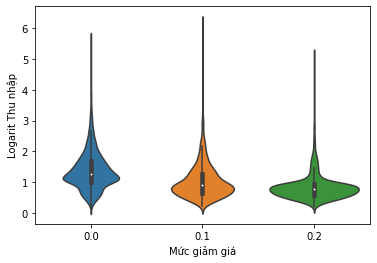

In [9]:
sns.violinplot(x= np.round(1 - df['price'].values, 3),
            y = df['income'].values)
        
plt.xlabel('Mức giảm giá')
plt.ylabel('Logarit Thu nhập')

Liệu chính sách như vậy có hợp lý không ? Ta có thể quan sát ảnh hưởng của chính sách này lên doanh số và doanh thu

Không có sự khác biệt rõ nét về doanh số giữa 3 mức giảm giá (dĩ nhiên khách hàng thu nhập thấp vẫn không mua nhiều sản phẩm ngay cả khi có giảm giá)

Text(0, 0.5, 'Logarit Doanh số')

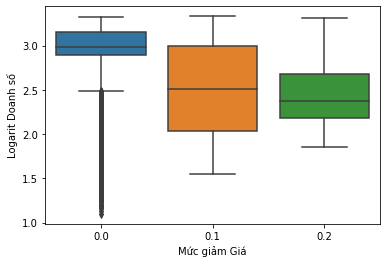

In [10]:
sns.boxplot(x= np.round(1 - df['price'].values, 3),
            y = np.log(df['demand']))
        
plt.xlabel('Mức giảm Giá')
plt.ylabel('Logarit Doanh số')

Về doanh thu, càng giảm giá nhiều thì doanh thu càng giảm:

### Dựng mô hình DML
Để ước lượng hiệu ứng can thiệp trung bình của chính sách giảm giá hiện tại, ta dùng mô hình DML, với package econML.

Mô hình có cơ chế như sau: một hệ thống gồm 2 mô hình bộ phận, mô hình T ước lượng giá trị của T (price) từ các features trong block W và X, mô hình Y ước lượng giá trị của Outcome Y (demand) từ các features trong block W và X. Sau đó ta dùng một mô hình thứ 3 tạm gọi là M, để ước lượng CATE (hiệu ứng can thiệp có điều kiện trung bình) dựa vào residual error của 2 mô hình T và Y.

T và Y được hoán chuyển logarit trước khi đi vào huấn luyện mô hình

In [11]:
# Chuẩn bị bloc dữ liệu cho mô hình DML

Y = df["demand"]  # Outcome
T = df["price"]  # Can thiệp
X = df[["income"]]  # Covariates
W = df.drop(columns=["demand", "price", "income"])  # Confounders

[Text(0, 0.5, 'Doanh số (log)'), Text(0.5, 0, 'Thu nhập')]

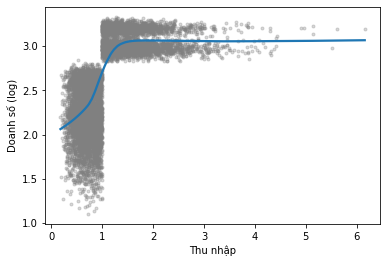

In [13]:
# Hoán chuyển T và Y thành thang đo logarit

log_T = np.log(T)
log_Y = np.log(Y)

g = sns.regplot(x=df['income'].values, 
            y=log_Y,z
            lowess = True, 
            marker = ".",
            scatter_kws={'alpha':0.3, 'color':'grey'})

g.set(xlabel='Thu nhập', ylabel='Doanh số (log)')

In [20]:
# Chuẩn bị array dữ liệu mô phỏng income để test mô hình
X_test = np.linspace(0, 5, 100).reshape(-1, 1)
X_test_data = pd.DataFrame(X_test, columns=["income"])

Ta chọn algorithm Random Forest cho cả 2 mô hình T và Y, vì đó là những bài toán regression, ước lượng biến số liên tục. Ưu điểm của Random Forest đó là không cần hoán chuyển dữ liệu features, thích nghi tốt với quy luật phi tuyến tính, và tốc độ huấn luyện nhanh.

Mô hình DML sau cùng ước tính CATE cũng dùng algorithm Random Forest

In [14]:
# Huấn luyện mô hình DML

mod = ForestDMLCateEstimator(model_y=RandomForestRegressor(), 
                             model_t=RandomForestRegressor())

mod.fit(log_Y, log_T, X, W, inference="blb")

Sau khi huấn luyện, mô hình (mod) cho phép ước tính marginal effect của CATE dựa vào duy nhất thông tin về thu nhập, hay hiệp biến X:

In [15]:
marg_ef = mod.marginal_effect(X = X.values, T = log_T)

ml, mu = mod.marginal_effect_interval(X = X.values, T=log_T)

Text(0, 0.5, 'Hiệu ứng can thiệp trên doanh số')

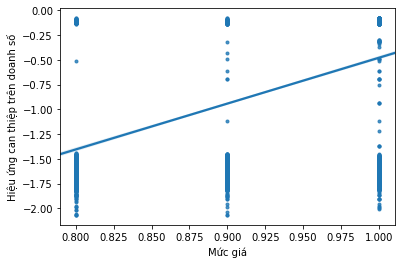

In [16]:
sns.regplot(x= df['price'].values,
                 y = marg_ef,
            marker = ".")
        
plt.xlabel('Mức giá')
plt.ylabel('Hiệu ứng can thiệp trên doanh số')

Biểu đồ boxplot cho thấy: chính sách giảm giá hiện thời có vẻ như không có hiệu quả: Mức giảm giá 20% có hại nhiều hơn lợi, nó làm giảm doanh số chứ không tăng. Mức giảm 10% có hiệu quả không rõ rệt, phân tán cao.

Text(0, 0.5, 'Hiệu ứng can thiệp trên doanh số')

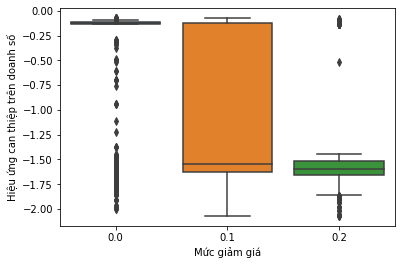

In [17]:
sns.boxplot(x= np.round(1 - df['price'].values, 3),
                 y = marg_ef)
        
plt.xlabel('Mức giảm giá')
plt.ylabel('Hiệu ứng can thiệp trên doanh số')

Vì thu nhập là 1 hiệp biến quan trọng, ta có thể khảo sát liên hệ giữa hiệu ứng can thiệp trung bình cùng khoảng tin cậy 95% với thu nhập qua biểu đồ sau

Text(0, 0.5, 'Hiệu quả của giảm giá trên doanh số')

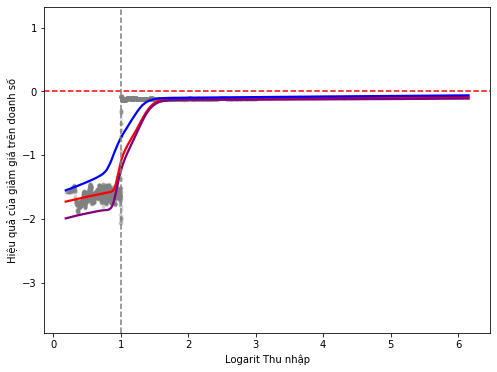

In [18]:
plt.figure(figsize=(8,6))
    
sns.regplot(x = df['income'].values,
            y =  marg_ef,
            lowess = True, marker = ".",
            color = 'red',
            ci = 95,
            scatter_kws={'alpha':0.1, 'color':'grey'})

sns.regplot(x = df['income'].values,
            y = ml,
            lowess = True, marker = ".",
            color = "purple",
            ci = 95,
            scatter_kws={'alpha':0, 'color':None})
    
sns.regplot(x = df['income'].values,
            y = mu,
            lowess = True, marker = ".",
            color = "blue",
            ci = 95,
            scatter_kws={'alpha':0, 'color':None})
    
plt.axhline(linewidth=1.5, linestyle = "--", color = "red")
plt.axvline(1,linestyle = "--", color = "grey")

plt.xlabel('Logarit Thu nhập')
plt.ylabel('Hiệu quả của giảm giá trên doanh số')

Hình ảnh này cho thấy hiệu quả của can thiệp giảm giá nói chung là âm (làm giảm doanh số), và diễn ra theo cùng quy luật quan hệ giữa Doanh số và thu nhập

Ta cũng có thể khảo sát tương tự cho dữ liệu income mô phỏng (test data)

In [22]:
# Ước tính hiệu ứng can thiệp theo giá trị mô phỏng của Income (X_test)

te_pred = mod.effect(X_test)
te_pred_interval = mod.effect_interval(X_test)

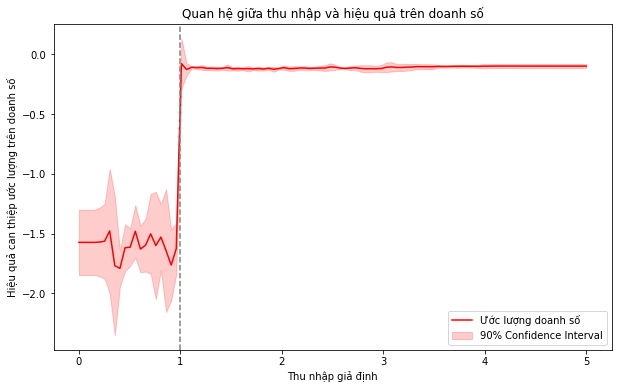

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(X_test.flatten(), te_pred, label="Ước lượng doanh số", color = 'red')

plt.fill_between(
    X_test.flatten(),
    te_pred_interval[0],
    te_pred_interval[1],
    alpha=0.2,
    color = 'red',
    label="90% Confidence Interval",
)

plt.axvline(1,linestyle = "--", color = "grey")

plt.xlabel("Thu nhập giả định")
plt.ylabel("Hiệu quả can thiệp ước lượng trên doanh số")
plt.title("Quan hệ giữa thu nhập và hiệu quả trên doanh số")
plt.legend(loc="lower right")

## Xây dựng chính sách dựa vào mô hình cây quyết định
Ngoài mô hình DML, package econML còn cung cấp cho chúng ta một công cụ rất thú vị, đó là mô hình cây quyết định cho phép giải thích mô hình DML dưới hình thức cây quyết định, và rút ra quy luật can thiệp tối ưu dựa vào kết quả mô hình DML.

Ở đây, ta muốn tối ưu hóa doanh thu (demand * price) chứ không phải là doanh số (demand)

Chúng ta muốn đưa ra quyết định: can thiệp giảm giá (khuyến mại) cho đối tượng khách hàng nào để tối đa doanh thu, với doanh thu được tính bằng tích của Giá (T) và doanh số (demand hay Y)

\begin{align}
Doanh thu Rev = Y \cdot T \\
     = \exp^{log(Y)} \cdot T\\
     = \exp^{(\theta(X) \cdot log(T) + f(X,W) + \epsilon)} \cdot T \\
     = \exp^{(f(X,W) + \epsilon)} \cdot T^{(\theta(X)+1)}
\end{align}

Khi giá (T) giảm, doanh thu chỉ tăng khi θ(X)+1<0.

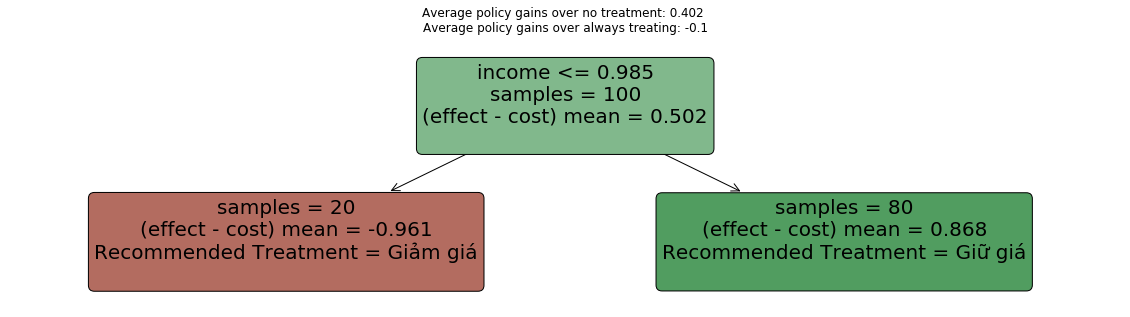

In [26]:
intrp = SingleTreePolicyInterpreter(risk_level=0.05, 
                                    max_depth=2, 
                                    min_samples_leaf=10, 
                                    min_impurity_decrease=0.001)
intrp.interpret(mod, X_test, 
                sample_treatment_costs=-1, 
                treatment_names=["Giảm giá", "Giữ giá"])

plt.figure(figsize=(20,5))

intrp.plot(feature_names=X.columns, fontsize=20)

### Algorithm SingleTreePolicyInterpreter của econML đề nghị chính sách giảm giá mới như sau:

Giảm giá 10% cho tất cả khách hàng có thu nhập thấp hơn 0.985, và giữ nguyên giá gốc (không giảm giá) cho tất cả đói tượng còn lại.
Trong thí nghiệm sau cùng, ta viết hàm để mô phỏng doanh thu tùy theo chính sách giảm giá (có giảm hay không: policy, giảm bao nhiêu: discount_level1, 2)

Với hàm mô phỏng này, ta so sánh doanh thu giữa 4 chính sách khác nhau:

1) Chính sách mới được đề nghị: chỉ có 2 mức: không giảm giá và giảm 0.1 (10%) dựa vào ngưỡng thu nhập 0.985.

2) Chính sách cũ hiện thời:

3) Chính sách giảm giá đồng loạt 10% cho tất cả khách hàng

4) Chính sách không giảm giá cho ai cả

In [27]:
def gamma_fn(X):
    return -3 - 14 * (X["income"] < 1)

def beta_fn(X):
    return 20 + 0.5 * (X["avg_hours"]) + 5 * (X["days_visited"] > 4)

def demand_fn(data, T):
    Y = gamma_fn(data) * T + beta_fn(data)
    return Y

# Hàm tính doanh thu

def revenue_fn(data, discount_level1, discount_level2, baseline_T, policy):
    policy_price = baseline_T * (1 - discount_level1) * policy + baseline_T * (1 - discount_level2) * (1 - policy)
    demand = demand_fn(data, policy_price)
    rev = demand * policy_price
    return rev

In [28]:
policy = intrp.treat(X)

policy

array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

In [29]:
policy_dic={}

# Chính sách giảm giá cho người có thu nhập < 0.985
policy = intrp.treat(X)

policy_dic["Chính sách mới"] = np.mean(revenue_fn(data = df, 
                                                  discount_level1 = 0, 
                                                  discount_level2 = 0.1, 
                                                  baseline_T = 1,
                                                  policy = policy))

## Chính sách cũ (như dữ liệu ghi nhận)
policy_dic["Chính sách cũ"] = np.mean(df["price"] * df["demand"])

## Chính sách: Giảm giá cho tất cả
policy_dic["GIảm giá cho tất cả"] = np.mean(revenue_fn(df, 0.1, 0, 1, np.ones(len(X))))

## Không giảm giá cho ai
policy_dic["Không giảm giá"] = np.mean(revenue_fn(df, 0, 0.1, 1, np.ones(len(X))))

Kết quả mô phỏng cho thấy Chính sách mà mô hình DML đề nghị là tốt nhất, vì sinh ra doanh thu cao nhất (14.682), tốt hơn chính sách cũ. Nếu không giảm giá cho ai thì doanh thu thấp hơn (14.295), nhưng nếu giảm cho tất cả khách hàng thì doanh thu sẽ sụt giảm nghiêm trọng.

In [30]:
policy_dic

{'Chính sách mới': 14.686241234917587,
 'Chính sách cũ': 14.349341914380455,
 'GIảm giá cho tất cả': 13.7744691160686,
 'Không giảm giá': 14.294605684520743}

In [31]:
res = pd.DataFrame.from_dict(policy_dic, 
                             orient="index", 
                             columns=["Doanh thu"])

res["Thứ hạng"] = res["Doanh thu"].rank(ascending=False)
res

,Doanh thu,Thứ hạng
Chính sách mới,14.686241,1.0
Chính sách cũ,14.349342,2.0
GIảm giá cho tất cả,13.774469,4.0
Không giảm giá,14.294606,3.0
